In [1]:
import psi4
psi4.core.set_output_file('output.log', True)
import numpy as np
import matplotlib.pyplot as plt
import py3Dmol
import nglview as nv
import glob
import os

In [2]:
import ipywidgets as widgets
from IPython.display import display

In [3]:
elements =          [None,
          'H' ,                                                                                'He',
          'Li','Be',                                                  'B' ,'C' ,'N' ,'O' ,'F' ,'Ne',
          'Na','Mg',                                                  'Al','Si','P' ,'S' ,'Cl','Ar',
          'K' ,'Ca','Sc','Ti','V' ,'Cr','Mn','Fe','Co','Ni','Cu','Zn','Ga','Ge','As','Se','Br','Kr',
          'Rb','Sr','Y' ,'Zr','Nb','Mo','Tc','Ru','Rh','Pd','Ag','Cd','In','Sn','Sb','Te','I' ,'Xe',
          'Cs','Ba','La', #Lantanides:  
#                  ---------------------------------------------------
                    'Ce','Pr','Nd','Pm','Sm','Eu','Gd',#
                    'Tb','Dy','Ho','Er','Tm','Yb','Lu',#
#                  ---------------------------------------------------
                         'Hf','Ta','W' ,'Re','Os','Ir','Pt','Au','Hg','Tl','Pb','Bi','Po','At','Rn',
         'Fr','Ra','Ac', #Actinides:
#                  ---------------------------------------------------
                   'Th','Pa','U' ,'Np','Pu','Am','Cm',#
                   'Bk','Cf','Es','Fm','Md','No','Lr'#
#                  ---------------------------------------------------
         ]


In [4]:
def cubetoxyz(cubefile):
    with open(cubefile) as f:
        atoms=[]
        line = f.readline()
        data = line.split()
        while len(data) != 6:
            line = f.readline()
            data = line.split()
            if len(data)==5:
                atoms.append(data)
    newxyz = str(len(atoms))+'\n'
    newxyz +='New xyz\n'
    for atom in atoms:
        xyz = [ '{:8.3f}'.format(float(x)*0.529177) for x in atom[2:]]
        newxyz += elements[int(atom[0])]+' '+' '.join(xyz)+'\n'
        
    return newxyz

def cubetopdb(cubefile):
    with open(cubefile) as f:
        atoms=[]
        line = f.readline()
        data = line.split()
        while len(data) != 6:
            line = f.readline()
            data = line.split()
            if len(data)==5:
                atoms.append(data)
    newpdb = 'TITLE pdb geometry'
    for i,atom in enumerate(atoms):
        atname=elements[int(atom[0])]
        xyz = [ float(x)*0.529177 for x in atom[2:]]
        line = "{:<6}{:>5d} {:<4}{:1}{:>3} {:1}{:>4d}{:1}   {:>8.3f}{:>8.3f}{:>8.3f}{:22}{:>2}".\
        format('HETATM',i+1,atname,' ','RES',' ',1,' ',*xyz,' ',atname)
        newpdb += "\n"+line
    return newpdb

In [5]:
def print_mo(mo,iso=0.02):
    # Search cubefile
    cubefiles=glob.glob('Psi_a_'+str(mo)+'_*')
    if len(cubefiles) > 1:
        print('Too many cubefiles for MO '+str(mo))
        return None
    if len(cubefiles) == 0:
        print('No cuefile for MO '+str(mo))
        return None
    cubefile=cubefiles[0]
    MO = open(cubefile).read()
    # xyz geom
    geomxyz = cubetoxyz(cubefile)
    view = py3Dmol.view()
    view.addModel(geomxyz,'xyz')
    view.setStyle({'sphere':{'scale':0.25}})
    view.addStyle({'stick':{'radius':0.1}})
    view.addVolumetricData(MO, "cube", {'isoval':  iso, 'color': "blue", 'opacity': 0.75})
    view.addVolumetricData(MO, "cube", {'isoval': -iso, 'color': "red", 'opacity': 0.75})
    view.rotate(0, {'x':1,'y':1,'z':1})
    view.zoomTo()
    
    return view, cubefile

In [6]:
def print_mo_geom(mo,geom,iso=0.02):
    # Search cubefile
    folder='GEOM_{:03g}'.format(geom)+'/'
    cubefiles=glob.glob(folder+'Psi_a_'+str(mo)+'_*')
    if len(cubefiles) > 1:
        print('Too many cubefiles for MO '+str(mo))
        return None
    if len(cubefiles) == 0:
        print('No cuefile for MO '+str(mo)+' at geom '+str(geom))
        return None
    cubefile=cubefiles[0]
    MO = open(cubefile).read()
    # xyz geom
    geomxyz = cubetoxyz(cubefile)
    view = py3Dmol.view()
    view.addModel(geomxyz,'xyz')
    view.setStyle({'sphere':{'scale':0.25}})
    view.addStyle({'stick':{'radius':0.1}})
    view.addVolumetricData(MO, "cube", {'isoval':  iso, 'color': "blue", 'opacity': 0.75})
    view.addVolumetricData(MO, "cube", {'isoval': -iso, 'color': "red", 'opacity': 0.75})
    view.rotate(0, {'x':1,'y':1,'z':1})
    view.zoomTo()
    
    return view, cubefile

In [7]:
def print_mo_geom_ngl(mo,geom,iso=0.02):
    # Search cubefile
    folder='GEOM_{:03g}'.format(geom)+'/'
    cubefiles=glob.glob(folder+'Psi_a_'+str(mo)+'_*')
    if len(cubefiles) > 1:
        print('Too many cubefiles for MO '+str(mo))
        return None
    if len(cubefiles) == 0:
        print('No cuefile for MO '+str(mo)+' at geom '+str(geom))
        return None
    cubefile=cubefiles[0]

    geofile='geom_tmp.pdb'
    with open(geofile,'w') as f:
        print(cubetopdb(cubefile),file=f)
    view = nv.show_file(geofile)
    #view = nv.NGLWidget()
    view.add_component(cubefile)
    view.component_1.clear()
    view.component_1.add_surface(opacity=0.5, color='blue', isolevel=1., probe_radius=10.)
    view.component_1.add_surface(opacity=0.5, color='red', isolevel=-1., depthWrite=False)
    view.parameters = {
        "clipNear": 0, "clipFar": 100, "clipDist": 1
    }
    
    return view, cubefile

In [8]:
def xyzfile2geom(fname,charge=None,mult=None,symm=None):
    '''Extact xyz geometry from xyz file (discarding 2 first lines)
    '''
    with open(fname) as fxyz:
        geomxyz = fxyz.read()
    # We can provide the geom without 2 first lines of xyz file. 
    # This allows additional input (such as units -ang by default- or symmetry)
    geo = geomxyz.split('\n')
    geo = '\n'.join(geo[2:])
    
    if charge is not None and mult is not None:
        geo = str(charge)+' '+str(mult)+'\n'+geo
        
    if symm:
        geo += '\nsymmetry '+symm
    
    return geo

# Input geometry and options

In [9]:
import os
from ipyfilechooser import FileChooser

In [10]:
path=os.getcwd()

# Create and display a FileChooser widget
fc = FileChooser(path)
display(fc)


FileChooser(path='/home/cerezo/Documentos/DOCENCIA/2020-21/QuiFiIII/UsingPsi4Jupyter', filename='', title='HTM…

In [11]:
# Print the selected path, filename, or both
print(fc.selected_path)
print(fc.selected_filename)
print(fc.selected)

None
None
None


In [12]:
geom = xyzfile2geom('geom.xyz',charge=0,mult=1)

In [13]:
print(geom)

0 1
C                     0.000000000000     0.000000000000    -1.623308221645
O                     0.000000000000     0.000000000000     1.217868248944



In [14]:
for w in dir(widgets):
    print(w)

Accordion
AppLayout
Audio
BoundedFloatText
BoundedIntText
Box
Button
ButtonStyle
CallbackDispatcher
Checkbox
Color
ColorPicker
Combobox
Controller
CoreWidget
DOMWidget
DatePicker
Datetime
Dropdown
FileUpload
FloatLogSlider
FloatProgress
FloatRangeSlider
FloatSlider
FloatText
GridBox
GridspecLayout
HBox
HTML
HTMLMath
Image
IntProgress
IntRangeSlider
IntSlider
IntText
Label
Layout
NumberFormat
Output
Password
Play
RadioButtons
Select
SelectMultiple
SelectionRangeSlider
SelectionSlider
SliderStyle
Style
Tab
Text
Textarea
ToggleButton
ToggleButtons
ToggleButtonsStyle
TwoByTwoLayout
VBox
Valid
ValueWidget
Video
Widget
__builtins__
__cached__
__doc__
__file__
__jupyter_widgets_base_version__
__jupyter_widgets_controls_version__
__loader__
__name__
__package__
__path__
__protocol_version__
__spec__
__version__
_handle_ipython
_version
dlink
docutils
domwidget
embed
fixed
get_ipython
handle_kernel
interact
interact_manual
interaction
interactive
interactive_output
jsdlink
jslink
link
load_ipyt

In [15]:
# Water
mol = psi4.geometry('''0 1
                       O 
                       H 1 1.0
                       H 1 1.0 2 104.5''')

In [16]:
# Diatomic
mol = psi4.geometry('''1 1
                       N 
                       O 1 1.0''')

In [17]:
mol.get_fragment_charges()

[1]

In [18]:
# Diatomic
mol = psi4.geometry('''1 1
                       N 0.0 0.0 0.0
                       O 0.0 0.0 1.0''')

In [19]:
mol.get_fragment_charges()

[1]

# Psi4 calculation

In [21]:
opt = psi4.core.get_options()

In [22]:
E, wfn = psi4.energy('b3lyp/6-31G(d)',return_wfn=True)

In [23]:
opt.print_module_options()

In [24]:
E, wfn = psi4.optimize('b3lyp/6-31G(d)',return_wfn=True)

Optimizer: Optimization complete!


# Geometric parameters

In [25]:
# Show current geom (modified if optizmiation was called)
print(mol.to_string('xyz'))

2
NO
N                     0.000000000000     0.000000000000    -0.572099314677
O                     0.000000000000     0.000000000000     0.500856005290



In [26]:
# Compute bond distance
geom = mol.geometry().np * 0.529177
np.linalg.norm(geom[1]-geom[0])

1.072954892814024

# Symmetry stuff

In [27]:
pg = mol.point_group()
ct = pg.char_table()
irep_symbol = [ ct.gamma(i).symbol() for i in range(pg.order()) ]
irep_symbol

['A1', 'A2', 'B1', 'B2']

# Molecular orbitals

In [28]:
# Compute cube files
%rm *cube
psi4.driver.p4util.cubeprop(wfn)

rm: no se puede borrar '*cube': No existe el archivo o el directorio


In [29]:
# Get MO energies. Per irrep 
mo_ener_symm = wfn.epsilon_a().nph
# Concatenate energies for all irrep in a single array
mo_ener=np.concatenate(mo_ener_symm)
# And sort by energy
mo_ener.sort()
# Show
mo_ener

array([-1.98057759e+01, -1.49994344e+01, -1.78401158e+00, -1.09903201e+00,
       -9.85903396e-01, -9.85903396e-01, -9.21002938e-01, -5.02689801e-01,
       -5.02689801e-01,  7.23215511e-03,  2.55840723e-01,  2.55840723e-01,
        2.78617952e-01,  3.20663952e-01,  4.27283363e-01,  5.21670509e-01,
        5.21670509e-01,  1.01675991e+00,  1.01675992e+00,  1.01992518e+00,
        1.13909530e+00,  1.13909530e+00,  1.54307979e+00,  1.54307982e+00,
        2.06088103e+00,  2.22931837e+00,  2.22931837e+00,  2.50289194e+00,
        2.86766986e+00,  3.22216512e+00])

In [30]:
view, cubefile = print_mo(1,iso=0.01)

In [31]:

view.animate({'loop': 'forward','reps': 10})
view.show()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [32]:
def display_mo(ind):
    i=ind
    view, cubefile = print_mo(i,iso=0.05)
    mo_name = cubefile.replace('.cube','')
    mo_name = mo_name.split('/')[-1]
    sym_label = mo_name.split('_')[-1]
    print('MO: {:<4}   E={:8.3f}     SymmLabel: {:4}'.format(i,mo_ener[i-1],sym_label))
    view.setPerceivedDistance(10)
    view.rotate(90, {'x':1,'y':1,'z':1})
    return view.show()

In [33]:
null = widgets.interact(display_mo, ind=widgets.IntSlider(min=1,max=10, step=1, description="MO"))

interactive(children=(IntSlider(value=1, description='MO', max=10, min=1), Output()), _dom_classes=('widget-in…

# Scan bond

In [34]:
# Diatomic
mol = psi4.geometry('''0 1
                       C 
                       O 1 1.0''')

In [35]:
E, wfn = psi4.optimize('b3lyp/6-31G(d)',return_wfn=True)

Optimizer: Optimization complete!


In [36]:
# Compute bond distance
geom = mol.geometry().np * 0.529177
np.linalg.norm(geom[1]-geom[0])

1.1378598433057072

In [38]:
# Dir things
%rm *cube GEOM_* -r
cwd = os.getcwd()+'/'

geom = mol.geometry().np
v = geom[1]-geom[0]
u = v/np.linalg.norm(v)
distances = np.linspace(0.7,3.5,35)
energies_success  = []
energies_failed   = []
distances_success = []
distances_failed  = []
for i,dist in enumerate(distances):
    geom = mol.geometry().np
    geom[1] = geom[0] + u*dist/psi4.constants.bohr2angstroms
    geom=psi4.core.Matrix.from_array(geom)
    mol.set_geometry(geom)
    geom = mol.geometry().np * 0.529177
    d = np.linalg.norm(geom[1]-geom[0])
    print('d={:8.3f}'.format(d))
    try: 
        e,wfn = psi4.energy('b3lyp/6-31G(d)',return_wfn=True)
        energies_success.append(e)
        distances_success.append(dist)
        psi4.driver.p4util.cubeprop(wfn)
        folder='GEOM_{:03g}'.format(i)+'/'
        os.mkdir(cwd+folder)
        cubefiles=glob.glob('Psi_*.cube')
        for file in cubefiles:
            os.rename(cwd+file,cwd+folder+file)
    except:
        distances_failed.append(dist)
        energies_failed.append(e)
        print('Distance: {:8.2f} - Energy: {:8.2f}'.format(dist,e))
        print('Failed')

rm: no se puede borrar '*cube': No existe el archivo o el directorio
d=   0.700
d=   0.782
d=   0.865
d=   0.947
d=   1.029
d=   1.112
d=   1.194
d=   1.276
d=   1.359
d=   1.441
d=   1.524
d=   1.606
d=   1.688
d=   1.771
d=   1.853
d=   1.935
d=   2.018
d=   2.100
d=   2.182
d=   2.265
d=   2.347
d=   2.429
d=   2.512
d=   2.594
d=   2.676
d=   2.759
d=   2.841
d=   2.924
Distance:     2.92 - Energy:  -112.78
Failed
d=   3.006
Distance:     3.01 - Energy:  -112.78
Failed
d=   3.088
Distance:     3.09 - Energy:  -112.78
Failed
d=   3.171
Distance:     3.17 - Energy:  -112.78
Failed
d=   3.253
Distance:     3.25 - Energy:  -112.78
Failed
d=   3.335
Distance:     3.34 - Energy:  -112.78
Failed
d=   3.418
Distance:     3.42 - Energy:  -112.78
Failed
d=   3.500
Distance:     3.50 - Energy:  -112.78
Failed


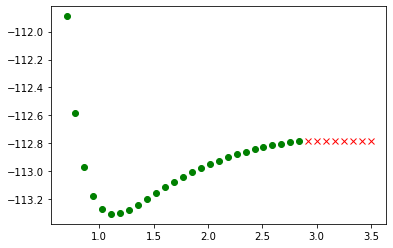

In [75]:
plt.plot(distances_success,energies_success,'og')
plt.plot(distances_failed,energies_failed,'xr')

## pymol3D

In [43]:
def display_mo_geom(mo,geom):
    i=mo
    view, cubefile = print_mo_geom(i,geom,iso=0.05)
    mo_name = cubefile.replace('.cube','')
    mo_name = mo_name.split('/')[-1]
    sym_label = mo_name.split('_')[-1]
    print('MO: {:<4}   E={:8.3f}     SymmLabel: {:4}'.format(i,mo_ener[i-1],sym_label))
    view.setPerceivedDistance(10)
    view.rotate(90, {'x':1,'y':1,'z':1})
    return view.show()

from ipywidgets import interactive

nmo = len(mo_ener)
ngeom = len(energies_success)+len(energies_failed)
interactive_plot = interactive(display_mo_geom, mo=(1,nmo,1), geom=(0, ngeom, 1))
output = interactive_plot.children[-1]
output.layout.height = '500px'
interactive_plot

interactive(children=(IntSlider(value=15, description='mo', max=30, min=1), IntSlider(value=17, description='g…

## nglview

In [71]:
ViewGlobal=False
def display_mo_geom_ngl(mo,geom):
    global ViewGlobal
    global camera
    i=mo
    if ViewGlobal:
        camera = ViewGlobal._camera_orientation
    view, cubefile = print_mo_geom_ngl(i,geom,iso=0.05)
    mo_name = cubefile.replace('.cube','')
    mo_name = mo_name.split('/')[-1]
    sym_label = mo_name.split('_')[-1]
    print('MO: {:<4}   E={:8.3f}     SymmLabel: {:4}'.format(i,mo_ener[i-1],sym_label))
    view._set_camera_orientation(camera)
    ViewGlobal = view
    return view

from ipywidgets import interactive

nmo = len(mo_ener)
ngeom = len(energies_success)+len(energies_failed)
interactive_plot = interactive(display_mo_geom_ngl, mo=(1,nmo,1), geom=(0, ngeom, 1))
output = interactive_plot.children[-1]
output.layout.height = '500px'
interactive_plot.auto_display=True
interactive_plot

interactive(children=(IntSlider(value=15, description='mo', max=30, min=1), IntSlider(value=17, description='g…

In [45]:
view, cubefile = print_mo_geom_ngl(5,1,iso=0.05)
view

NGLWidget()

In [46]:
camera = view._camera_orientation

In [51]:
type(camera)

list

In [64]:
Views=[1]

In [65]:
def ttt():
    if Views:
        print(type(Views))

In [66]:
ttt()

<class 'list'>


# Testing

In [ ]:
import ipywidgets as widgets
from IPython.display import display

In [ ]:
widgets.IntSlider(
    min=0,
    max=10,
    step=1,
    description='Slider:',
    value=3
)

In [ ]:
slider = widgets.IntSlider()
display(slider)

In [ ]:
slider = widgets.IntSlider(
    min=0,
    max=10,
    step=1,
    description='MO:',
    value=3
)
text = widgets.IntText()
display(slider, text)
i = int(slider.value)
print(i*10)

null = widgets.jslink((slider, 'value'), (text, 'value'))

In [ ]:
text.get_state()

In [ ]:


%matplotlib inline
from ipywidgets import interactive
import matplotlib.pyplot as plt
import numpy as np

def f(m, b):
    plt.figure(2)
    x = np.linspace(-10, 10, num=1000)
    plt.plot(x, m * x + b)
    plt.ylim(-5, 5)
    plt.show()

interactive_plot = interactive(f, m=(-2.0, 2.0), b=(-3, 3, 0.5))
output = interactive_plot.children[-1]
output.layout.height = '350px'
interactive_plot



In [73]:
caption = widgets.Label(value='Changes in source values are reflected in target1')
source, target1 = widgets.IntSlider(description='Source'),\
                  widgets.IntSlider(description='Target 1')
dl = widgets.dlink((source, 'value'), (target1, 'value'))
display(caption, source, target1, view)



Label(value='Changes in source values are reflected in target1')

IntSlider(value=0, description='Source')

IntSlider(value=0, description='Target 1')

NGLWidget(n_components=2)